In [1]:
%load_ext jupyter_black

In [2]:
# glob is just a allows for wild card pattern matching
from glob import glob

import numpy as np

from griblib.hrrr import open_gribs

In [3]:
# glob("/workspaces/griblib/notebooks/alaska/demo/20220720.alaska.t00z.wrfnatf00.ak.grib2")
hrrr = open_gribs(glob("/workspaces/griblib/notebooks/alaska/demo/*.grib2"))
hrrr

XarrayHrrr.properties(geopotential_height, pressure, unknown, mixing_ratio, graupel, particulate_matter, fraction_of_cloud_cover, temperature, specific_humidity, u_component_of_wind, v_component_of_wind, vertical_velocity, turbulent_kinetic_energy, derived_radar_reflectivity, atmosphere, isothermal, hybrid, height_above_ground_layer, iterfiles, multi_file_dataset)

In [4]:
refd = hrrr.derived_radar_reflectivity()
refd

<xarray.Dataset>
Dimensions:     (y: 919, x: 1299, valid_time: 2)
Coordinates:
    latitude    (y, x) float64 dask.array<chunksize=(919, 1299), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(919, 1299), meta=np.ndarray>
  * valid_time  (valid_time) datetime64[ns] 2022-07-20T01:00:00 2022-07-20
Dimensions without coordinates: y, x
Data variables:
    refd        (valid_time, y, x) float32 dask.array<chunksize=(1, 919, 1299), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-07-27T13:31 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
refd.to_array()

<xarray.DataArray 'stack-cb6e62f522da1c3136660cc713cdb7ce' (variable: 1,
                                                            valid_time: 2,
                                                            y: 919, x: 1299)>
dask.array<stack, shape=(1, 2, 919, 1299), dtype=float32, chunksize=(1, 1, 919, 1299), chunktype=numpy.ndarray>
Coordinates:
    latitude    (y, x) float64 dask.array<chunksize=(919, 1299), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(919, 1299), meta=np.ndarray>
  * valid_time  (valid_time) datetime64[ns] 2022-07-20T01:00:00 2022-07-20
  * variable    (variable) <U4 'refd'
Dimensions without coordinates: y, x
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-07-27T13:31 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
# convert the xarray dataset to a pandas dataframe and specify the order of the columns
refdf = refd.to_dataframe(["valid_time", "x", "y"])
refdf

latitude   longitude  refd
valid_time          x    y                               
2022-07-20 01:00:00 0    0    41.612949  185.117126 -10.0
                         1    41.631410  185.096483 -10.0
                         2    41.649867  185.075822 -10.0
                         3    41.668322  185.055143 -10.0
                         4    41.686774  185.034446 -10.0
...                                 ...         ...   ...
2022-07-20 00:00:00 1298 914  76.229950  244.066563 -10.0
                         915  76.256884  244.105754 -10.0
                         916  76.283813  244.145100 -10.0
                         917  76.310738  244.184603 -10.0
                         918  76.337657  244.224263 -10.0

[2387562 rows x 3 columns]

In [7]:
# NOTE: longitude values are 0~360, to fix that
# SEE: https://confluence.ecmwf.int/pages/viewpage.action?pageId=149337515
df = refdf.copy()
(df["longitude"] + 180) % 360 - 180
df["longitude"].agg(["min", "max"])

min    156.436843
max    244.224263
Name: longitude, dtype: float64

In [8]:
# avaliable validtimes
vt = df.index.unique("valid_time")
vt

DatetimeIndex(['2022-07-20 01:00:00', '2022-07-20 00:00:00'], dtype='datetime64[ns]', name='valid_time', freq=None)

In [9]:
# resolution (x,y)
res = df.index.get_level_values("x").max(), df.index.get_level_values("y").max()
res

(1298, 918)

# plotting
- matplotlib
- catropy

The Pandas Dataframe has a [plot](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.plot.html) accessor.
This is basicly an interface to matplotlib in the backend

In [10]:
df["longitude"].agg(["min", "max"])

min    156.436843
max    244.224263
Name: longitude, dtype: float64

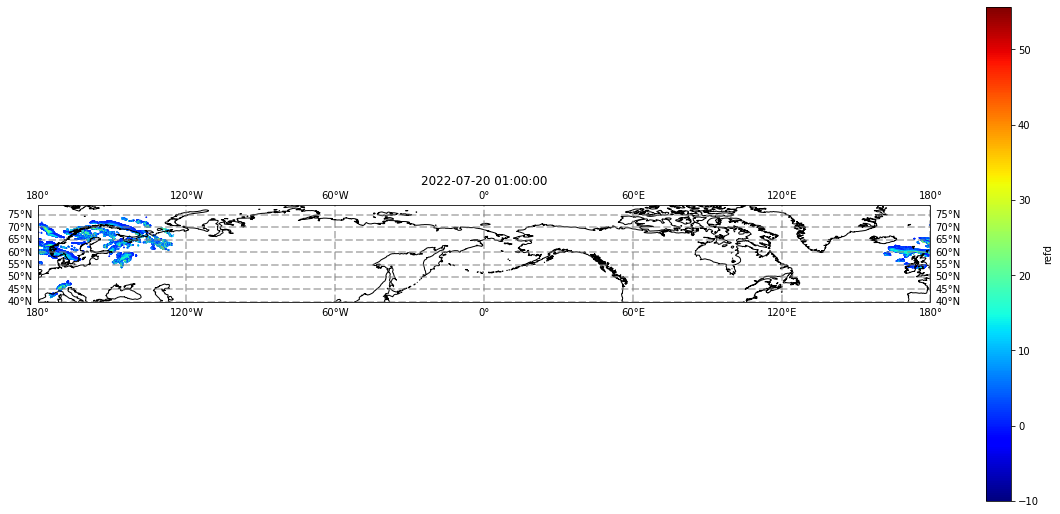

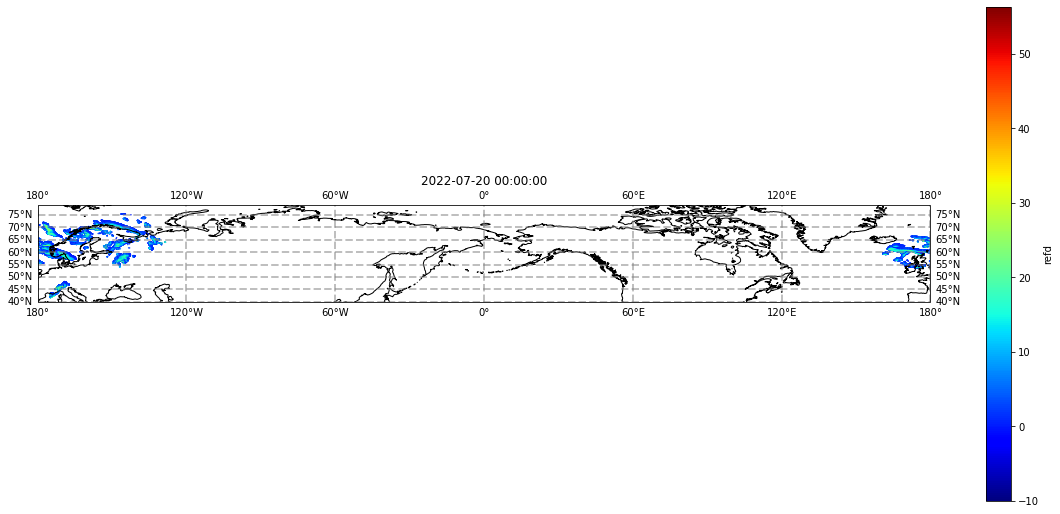

In [17]:
from typing import Iterator
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs

# cartopy.mpl.geoaxes.GeoAxesSubplot
from cartopy.mpl.geoaxes import GeoAxesSubplot


def iterplot(df: pd.DataFrame) -> Iterator[tuple[pd.Timestamp, pd.DataFrame]]:
    df["longitude"] = (df["longitude"] + 180) % 360 - 180
    yield from df.groupby("valid_time")


# may need
for vt, frame in iterplot(df.copy()):
    plt.figure(vt.value)
    plt.title(vt)
    ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=-180))
    ax.coastlines("50m")

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(central_longitude=-180),
        draw_labels=True,
        linewidth=2,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )

    # ax.set_extent(
    #     [
    #         *df["longitude"].agg(["min", "max"]),
    #         *df["latitude"].agg(["min", "max"]),
    #     ],
    #     projection,
    # )
    frame.plot.scatter(
        title=vt,
        x="longitude",
        y="latitude",
        c="refd",
        cmap=plt.get_cmap("jet"),
        alpha=np.where(frame["refd"] > 0, 1, 0),
        ax=ax,
        figsize=(20, 20),
        s=0.25,
    )

In [19]:
frame["longitude"]

valid_time  x     y  
2022-07-20  0     0     -174.882874
                  1     -174.903517
                  2     -174.924178
                  3     -174.944857
                  4     -174.965554
                            ...    
            1298  914   -115.933437
                  915   -115.894246
                  916   -115.854900
                  917   -115.815397
                  918   -115.775737
Name: longitude, Length: 1193781, dtype: float64